# Breast cancer detection with decision trees

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import sys
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm

sys.path.append("..")
from models.decision_tree import DecisionTreeClassifier, DecisionTreeRegressor
from models.logistic_regression import LogisticRegression
from models.ensemble import BaggingClassifier, GradientBoostingClassifier

In [2]:
%matplotlib inline
# Reproducibility.
np.random.seed(1)

### Load data 
The breast cancer dataset contains 30 features corresponding to the mean, standard error, and worst case, of 10 different measures, which in order they are: 

* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension (“coastline approximation” - 1)

In [3]:
# Load and shuffle the data
(X, y) = load_breast_cancer(return_X_y=True)
n_samples, n_features = X.shape
print("There are {} samples with {} features each.".format(n_samples, n_features))

perm = np.random.permutation(n_samples)
X, y = X[perm, :], y[perm]

# Mean and standar deviation of each feature:
print("The mean of each feature is: {}".format(X.mean(axis=0)))
print("The standar deviation of each feature is: {}".format(X.std(axis=0)))

There are 569 samples with 30 features each.
The mean of each feature is: [1.41272917e+01 1.92896485e+01 9.19690334e+01 6.54889104e+02
 9.63602812e-02 1.04340984e-01 8.87993158e-02 4.89191459e-02
 1.81161863e-01 6.27976098e-02 4.05172056e-01 1.21685343e+00
 2.86605923e+00 4.03370791e+01 7.04097891e-03 2.54781388e-02
 3.18937163e-02 1.17961371e-02 2.05422988e-02 3.79490387e-03
 1.62691898e+01 2.56772232e+01 1.07261213e+02 8.80583128e+02
 1.32368594e-01 2.54265044e-01 2.72188483e-01 1.14606223e-01
 2.90075571e-01 8.39458172e-02]
The standar deviation of each feature is: [3.52095076e+00 4.29725464e+00 2.42776193e+01 3.51604754e+02
 1.40517641e-02 5.27663291e-02 7.96497253e-02 3.87687325e-02
 2.73901809e-02 7.05415588e-03 2.77068942e-01 5.51163427e-01
 2.02007710e+00 4.54510134e+01 2.99987837e-03 1.78924359e-02
 3.01595231e-02 6.16486075e-03 8.25910439e-03 2.64374475e-03
 4.82899258e+00 6.14085432e+00 3.35730016e+01 5.68856459e+02
 2.28123569e-02 1.57198171e-01 2.08440875e-01 6.56745545e-0

To achieve better performance, at least with our logistic regression baseline model, we may standarize the data:

In [4]:
X = (X- X.mean(axis=0))/X.std(axis=0)

### Cross validation function

In [5]:
def cross_validate(model, k):
    X_fold = X
    y_fold = y
    pivot = int(X_fold.shape[0]/k)
    cum_acc = 0
    for _ in tqdm(range(k)):
        # Always take firt fold as test
        x_test, y_test = X_fold[:pivot, :], y_fold[:pivot]
        x_train, y_train = X_fold[pivot:, :], y_fold[pivot:]
        
        # fit the model
        model.fit(X=x_train, y=y_train)
        y_hat = model.predict(x_test)
        
        cum_acc += balanced_accuracy_score(y_test, y_hat)
        
        X_fold = np.concatenate((x_train, x_test))
        y_fold = np.concatenate((y_train, y_test))
        
    return cum_acc/k

### Define a logistic regression baseline

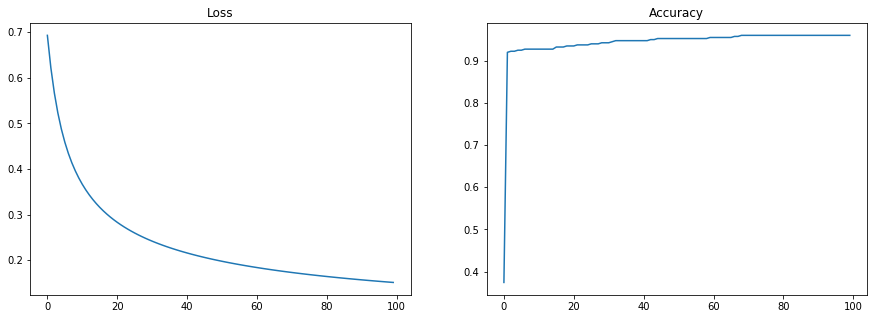

Accuracy on the test set: 0.9883040935672515
Balanced Accuracy on the test set: 0.9841269841269842


In [6]:
# Initialize and fit the model.
model = LogisticRegression(n_features=n_features)
loss, acc = model.fit(X[:int(0.7*n_samples), :], y[:int(0.7*n_samples)], iterations=100, learning_rate=1e-4)

# Visualize training.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])

ax1.plot(loss)
ax1.set_title('Loss')

ax2.plot(acc)
ax2.set_title('Accuracy')

plt.show()

# Evaluate on a held-out set
y_pred = model.predict(X[int(0.7*n_samples):])
acc = np.mean(np.round(y_pred)==y[int(0.7*n_samples):])
print("Accuracy on the test set: {}".format(acc))
print("Balanced Accuracy on the test set: {}".format(balanced_accuracy_score(y[int(0.7*n_samples):], np.round(y_pred))))

The balanced-accuracy to beat is around 0.984, lets try with a single tree:

In [ ]:
tree = DecisionTreeClassifier(max_depth=10, min_impurity=0.05)
tree.fit(X[:int(0.7*n_samples), :], y[:int(0.7*n_samples)])

# Evaluate on train and test set.
y_pred = tree.predict(X[:int(0.7*n_samples), :])
acc = np.mean(y_pred==y[:int(0.7*n_samples)])
print("Accuracy on the train set: {}".format(acc))

y_pred = tree.predict(X[int(0.7*n_samples):, :])
acc = np.mean(y_pred==y[int(0.7*n_samples):])
print("Accuracy on the test set: {}".format(acc))
print("Balanced Accuracy on the test set: {}".format(balanced_accuracy_score(y[int(0.7*n_samples):], np.round(y_pred))))

A single tree is not capable of beating the logistic regression model. Will a combination of these?

## Ensembling

### Bagging
Let's try first with a simple bag of trees

In [ ]:
# Create the model
base_tree = DecisionTreeClassifier(max_depth=15, min_impurity=0.1)
bag_trees = BaggingClassifier(base_tree, n_models=50)

# Validate
acc = cross_validate(bag_trees, 5)
print("Cross-Validation accuracy: %.3f" % acc)

### Random forest

In [ ]:
# Create the model
base_tree = DecisionTreeClassifier(max_depth=15, min_impurity=0.1, p=np.sqrt(n_features)/n_features)
bag_trees = BaggingClassifier(base_tree, n_models=100)

# Validate
acc = cross_validate(bag_trees, 5)
print("Cross-Validation accuracy: %.3f" % acc)

### Boosting

In [9]:
# Create the model
base_tree = DecisionTreeRegressor(max_depth=3)
boosted_trees = GradientBoostingClassifier(base_tree, learning_rate=0.05, max_models=100)

# Validate
acc = cross_validate(boosted_trees, 5)
print("Cross-Validation accuracy: %.2f" % acc)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Fitting model nº1
Current loss: 0.7977252887803212
new loss: 0.18278157999222214
Found Rho=28.586389967108317, after 10609 steps
Fitting model nº2
Current loss: 0.7246999285809234
new loss: 0.1766791280866352
Found Rho=24.03946286168805, after 6725 steps
Fitting model nº3
Current loss: 0.659248041713302
new loss: 0.16317304097470672
Found Rho=20.835171901235743, after 4689 steps
Fitting model nº4
Current loss: 0.5977834735788778
new loss: 0.15577909232576326
Found Rho=17.90241920803098, after 3226 steps
Fitting model nº5
Current loss: 0.5403300777298207
new loss: 0.15197213060075784
Found Rho=15.302710136042853, after 2222 steps
Fitting model nº6
Current loss: 0.4873453249728895
new loss: 0.1502119715360159
Found Rho=13.058265374757584, after 1550 steps
Fitting model nº7
Current loss: 0.43932978979931964
new loss: 0.14956310277877966
Found Rho=11.149384028438737, after 1103 steps
Fitting model nº8
Current loss: 0.396659947913778
new loss: 0.1494743975809244
Found Rho=9.570622613408478,

Current loss: 0.15188002521453114
new loss: 0.15173250341013353
Found Rho=0.2485001933625329, after 8 steps
Fitting model nº66
Current loss: 0.1518640563874951
new loss: 0.15172971278957204
Found Rho=0.21747784312632815, after 7 steps
Fitting model nº67
Current loss: 0.15185085927840264
new loss: 0.15173146051286618
Found Rho=0.21755978421166983, after 7 steps
Fitting model nº68
Current loss: 0.1518383770319821
new loss: 0.15173380639217102
Found Rho=0.21764098326914966, after 7 steps
Fitting model nº69
Current loss: 0.15182660416800364
new loss: 0.15173040160939988
Found Rho=0.1865726520510521, after 6 steps
Fitting model nº70
Current loss: 0.15181707595136243
Converged, loss improvement: 9.528216641213616e-06


 20%|████████████████▌                                                                  | 1/5 [02:24<09:38, 144.65s/it]

Fitting model nº1
Current loss: 0.7991711950943517
new loss: 0.20182360802936172
Found Rho=27.114172313084513, after 8640 steps
Fitting model nº2
Current loss: 0.7250249159840251
new loss: 0.1457199355146264
Found Rho=24.31102608114704, after 5909 steps
Fitting model nº3
Current loss: 0.6517798776173392
new loss: 0.15139936275034965
Found Rho=19.560297202109208, after 3819 steps
Fitting model nº4
Current loss: 0.5884606504165036
new loss: 0.14450105288787626
Found Rho=16.9317836278203, after 2655 steps
Fitting model nº5
Current loss: 0.52931580750041
new loss: 0.14108851049249102
Found Rho=14.597960747260245, after 1851 steps
Fitting model nº6
Current loss: 0.47480885512138826
new loss: 0.14091886155664934
Found Rho=12.448448267397673, after 1297 steps
Fitting model nº7
Current loss: 0.42601304761828723
new loss: 0.14041800046904987
Found Rho=10.738316195967007, after 937 steps
Fitting model nº8
Current loss: 0.3826995764835836
new loss: 0.14046429537690094
Found Rho=9.310759220019278,

Current loss: 0.13850912699063733
new loss: 0.13820535917293347
Found Rho=0.35570907597021606, after 11 steps
Fitting model nº66
Current loss: 0.138476718777825
new loss: 0.13833502933629424
Found Rho=0.22634133996369835, after 7 steps
Fitting model nº67
Current loss: 0.13846261391302958
new loss: 0.13833715987418593
Found Rho=0.22641411644195397, after 7 steps
Fitting model nº68
Current loss: 0.1384492759663972
new loss: 0.13833431302024427
Found Rho=0.19408996830390784, after 6 steps
Fitting model nº69
Current loss: 0.1384384523860199
new loss: 0.13833562946730257
Found Rho=0.19414287427293297, after 6 steps
Fitting model nº70
Current loss: 0.13842818537971172
new loss: 0.13833743476853877
Found Rho=0.1941954063671324, after 6 steps
Fitting model nº71
Current loss: 0.13841847188252124
Converged, loss improvement: 9.71349719047776e-06


 40%|█████████████████████████████████▏                                                 | 2/5 [04:58<07:21, 147.29s/it]

Fitting model nº1
Current loss: 0.7963749091613539
new loss: 0.20520648725000962
Found Rho=31.263361909645624, after 12345 steps
Fitting model nº2
Current loss: 0.7244205557739939
new loss: 0.18300048149582737
Found Rho=27.329516067571642, after 8681 steps
Fitting model nº3
Current loss: 0.6577883306953081
new loss: 0.1848661713573639
Found Rho=21.709742973433364, after 5515 steps
Fitting model nº4
Current loss: 0.5998364105287508
new loss: 0.17654765178179294
Found Rho=18.714311751113776, after 3779 steps
Fitting model nº5
Current loss: 0.5451209585383987
new loss: 0.1719765922145873
Found Rho=16.05993086092111, after 2591 steps
Fitting model nº6
Current loss: 0.4941536227640905
new loss: 0.16963337368361542
Found Rho=13.752079437967922, after 1797 steps
Fitting model nº7
Current loss: 0.44755202813788925
new loss: 0.1685733077249213
Found Rho=11.805338594802857, after 1273 steps
Fitting model nº8
Current loss: 0.4057360246715878
new loss: 0.16821115900925185
Found Rho=10.173802590069

Current loss: 0.16871297667101864
new loss: 0.1685487635763133
Found Rho=0.2611377783088182, after 9 steps
Fitting model nº66
Current loss: 0.16869691727314579
new loss: 0.1685498560304555
Found Rho=0.26123524461077385, after 9 steps
Fitting model nº67
Current loss: 0.16868169103568717
new loss: 0.16854776735054774
Found Rho=0.23225106398113893, after 8 steps
Fitting model nº68
Current loss: 0.16866885249260682
new loss: 0.16854858627182392
Found Rho=0.2323271065576668, after 8 steps
Fitting model nº69
Current loss: 0.16865666424764286
new loss: 0.16854997975890215
Found Rho=0.23240256143303967, after 8 steps
Fitting model nº70
Current loss: 0.16864512266033646
new loss: 0.16854735704358723
Found Rho=0.20337964848814896, after 7 steps
Fitting model nº71
Current loss: 0.1686355517694502
Converged, loss improvement: 9.570890886267946e-06


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [07:36<05:01, 150.52s/it]

Fitting model nº1
Current loss: 0.7982942103157974
new loss: 0.19140721184674508
Found Rho=30.357925843443496, after 10290 steps
Fitting model nº2
Current loss: 0.7198730611272625
new loss: 0.20058971738993187
Found Rho=22.11428966989522, after 6167 steps
Fitting model nº3
Current loss: 0.6594471769779567
new loss: 0.18102284443662858
Found Rho=20.713739234943162, after 4505 steps
Fitting model nº4
Current loss: 0.598576968743005
new loss: 0.1802957574457948
Found Rho=17.54268020567463, after 3015 steps
Fitting model nº5
Current loss: 0.5425898695019432
new loss: 0.17240342824479876
Found Rho=15.812952511690352, after 2126 steps
Fitting model nº6
Current loss: 0.488065816132749
new loss: 0.17192368258442564
Found Rho=12.682206361288785, after 1460 steps
Fitting model nº7
Current loss: 0.4423739314136873
new loss: 0.16896890757482588
Found Rho=11.110595279863501, after 1061 steps
Fitting model nº8
Current loss: 0.40088642845111766
new loss: 0.1670484156213045
Found Rho=9.777393945190717

Current loss: 0.1624220157675988
new loss: 0.16231063112277516
Found Rho=0.2788303443156578, after 9 steps
Fitting model nº66
Current loss: 0.16241006893388038
new loss: 0.1623091410745825
Found Rho=0.24788050560147326, after 8 steps
Fitting model nº67
Current loss: 0.16240004262373955
new loss: 0.16231044950016052
Found Rho=0.24793644055721104, after 8 steps
Fitting model nº68
Current loss: 0.162390568410029
Converged, loss improvement: 9.474213710558566e-06


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [10:08<02:31, 151.03s/it]

Fitting model nº1
Current loss: 0.7969012322386521
new loss: 0.22766971560467067
Found Rho=27.521099998559745, after 10383 steps
Fitting model nº2
Current loss: 0.7309182919749396
new loss: 0.23229306725475568
Found Rho=23.151692560809934, after 7224 steps
Fitting model nº3
Current loss: 0.6737967420483533
new loss: 0.21173869023038344
Found Rho=20.53552125486003, after 5163 steps
Fitting model nº4
Current loss: 0.6185844646350287
new loss: 0.20448800681240004
Found Rho=17.82169539000102, after 3541 steps
Fitting model nº5
Current loss: 0.5662073878316399
new loss: 0.19455182575642138
Found Rho=15.680228526808255, after 2484 steps
Fitting model nº6
Current loss: 0.5160157157021649
new loss: 0.1878365721664937
Found Rho=13.775584968304358, after 1755 steps
Fitting model nº7
Current loss: 0.4686652671329751
new loss: 0.18328064110619327
Found Rho=12.122718962560258, after 1260 steps
Fitting model nº8
Current loss: 0.42479933768666167
new loss: 0.18017233102381794
Found Rho=10.69833102173

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:16<00:00, 144.21s/it]


Cross-Validation accuracy: 0.89
